# Density

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import itertools
import matplotlib.animation as animation

import sys
sys.path.append("../src/")

import analysis
import partition_energy
import chl_xtb


In [268]:
run = "10ps_2fs"
fr = 10

hamils = partition_energy.read_splits("hamiltonians", (1000, 28, 28), run)
distances = partition_energy.read_splits("distances", (1000, 27, 27), run)
eigvec = partition_energy.read_splits("eigenvectors", (1000, 28, 28), run)

eigvec = np.transpose(eigvec, (0, 2, 1))

density = np.square(eigvec)

eigval = partition_energy.read_splits("states_energies", (1000, 28), run)

for d, H, vec, val in zip(distances, hamils, eigvec, eigval):
    assert(np.max(val - reconstruct_val(vec, H)) < 1e-10)
    assert(check_symmetric(H))

    assert(check_symmetric(d))
    
site_e = partition_energy.read_splits("transition_energies", (1000, 27), run)

array([ 0,  8, 19])

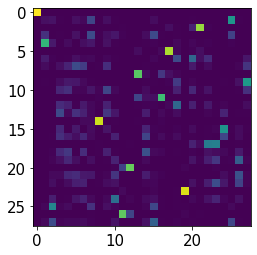

In [180]:
plt.imshow(np.square(eigvec[0]))

np.where(np.max(np.square(eigvec[0]), axis=0) > 0.9)[0]

<BarContainer object of 28 artists>

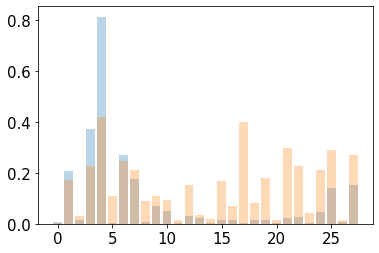

In [370]:



args, max_overlaps = follow_eigenstate(1)

k=14

plt.bar(range(28), abs(eigvec[0][:, 1]), alpha=0.3)
#plt.bar(range(28), abs(eigvec[max(k-1, 0)][:, int(args[max(k-1,0)])]), alpha=0.3)
plt.bar(range(28), abs(eigvec[k][:, int(args[k])]), alpha=0.3)

#print(max_overlaps7[k])
#print(np.abs(np.dot(eigvec[k][:, args[k]], eigvec[max(k-1, 0)][:,args[max(k-1, 0)]])))

#plt.plot(max_overlaps)


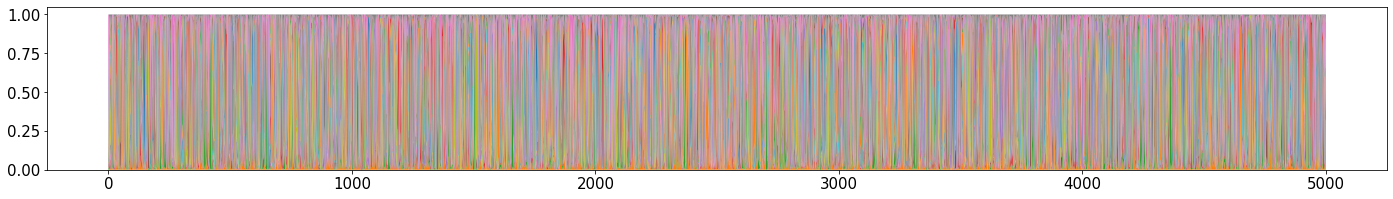

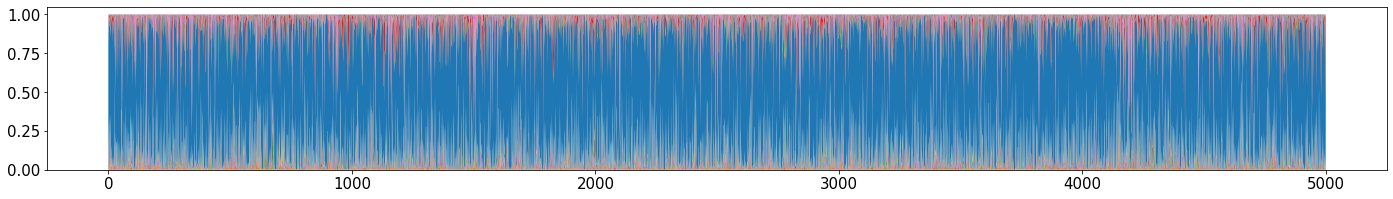

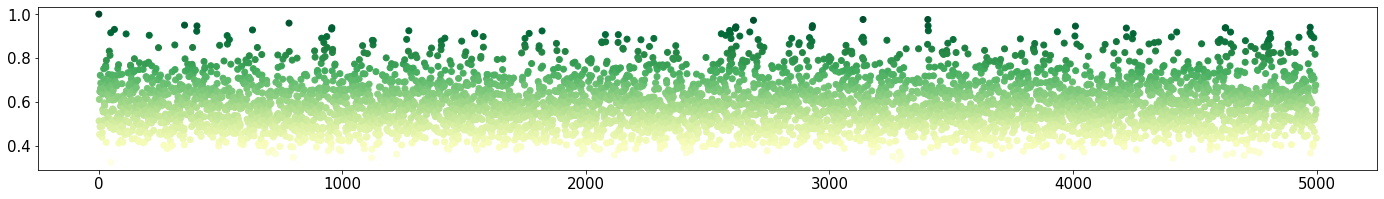

In [409]:
length = 5000

start = 12

fig, ax = plt.subplots(figsize=(24,3))

y = np.empty((28, length))

for f in range(length):
    y[:, f] = eigvec[f][:, start]

check = (hamils[0] @ y[:,0]) / y[:,0]

for i in range(28):
    assert(np.abs(np.mean(check) - check[i]) < 1e-6)
    
ax.stackplot(range(length), np.square(y));

fig, ax = plt.subplots(figsize=(24,3))

followed = np.empty((28, length))

for f in range(length):
    if f == 0:
        followed[:, f] = eigvec[f][:, start]
        
    else:
        prev_eigvec = followed[:, 0]

        overlaps = [np.abs(np.dot(eigvec[f][:, i], prev_eigvec)) for i in range(28)]

        arg = np.argmax(overlaps)
        max_overlap = overlaps[arg]
        
        followed[:, f] = eigvec[f][:, arg]

check = (hamils[0] @ y[:,0]) / y[:,0]

for i in range(28):
    assert(np.abs(np.mean(check) - check[i]) < 1e-6)

ax.stackplot(range(length), np.square(followed));

fig, ax = plt.subplots(figsize=(24, 3))

ax.scatter(range(length), max_overlaps[:length], c=max_overlaps[:length], cmap='YlGn')

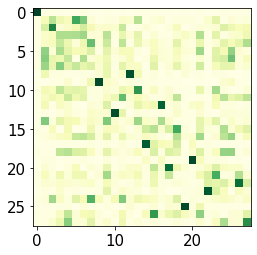

In [120]:
overlaps = np.empty((28, 28))

k=17

for i in range(28):
    for j in range(28):
        overlaps[i][j] = np.abs(np.dot(eigvec[k][:, i], eigvec[max(k-1, 0)][:, j]))

plt.imshow(overlaps, cmap='YlGn')

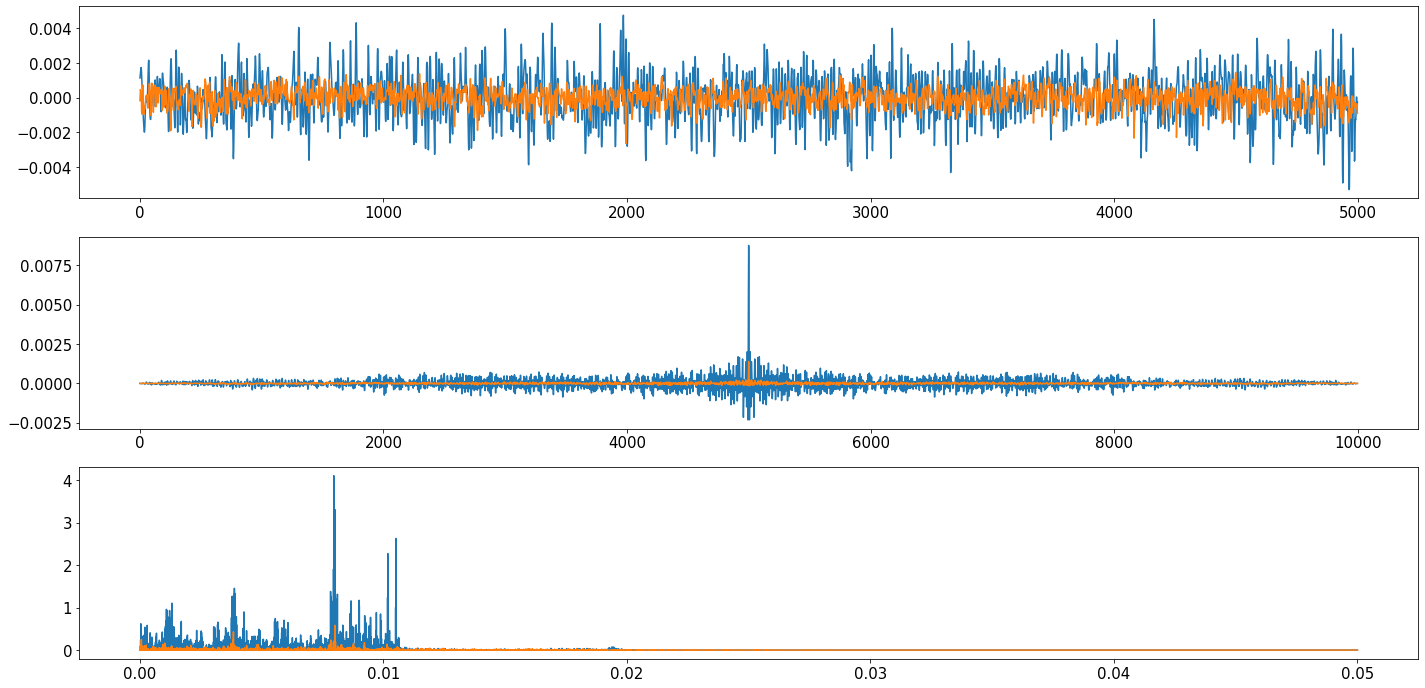

In [267]:
def spectral_density(series, frame_rate, ax):
    s_rel = series - np.mean(series)

    autocorr, spectrum, spectrum_normal_domain = analysis.spectrum_and_domain(s_rel, frame_rate)
    
    ax[0].plot(s_rel)
    ax[1].plot(autocorr[:len(autocorr)//5])
    ax[2].plot(analysis.first_half(spectrum_normal_domain), analysis.first_half(np.abs(spectrum)))

site_e_by_overlap = np.array([site_e[i, k-1] for i, k in enumerate(args)])

fig, ax = plt.subplots(3, 1, figsize=(24, 12))

spectral_density(site_e[:,0], fr, ax)
spectral_density(eigval[:, 1] - eigval[:, 0] * 1.0, fr, ax)
#spectral_density(site_e_by_overlap*2, fr, ax)


[-1.77635684e-15  6.66133815e-16 -1.66533454e-16  7.21644966e-16
 -5.55111512e-16]
4.718447854656915e-16
7.771561172376096e-16


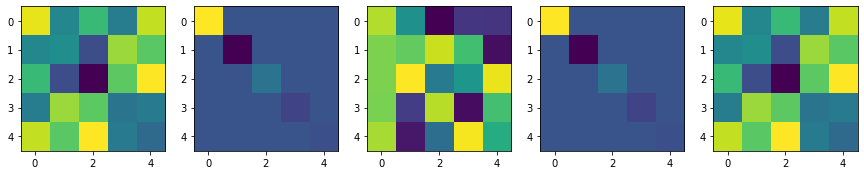

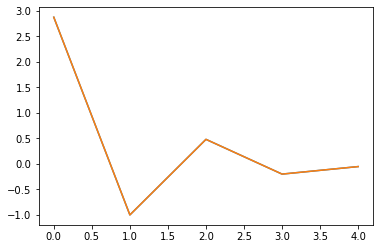

In [17]:
fig, ax = plt.subplots(1, 5)

H = np.random.uniform(size=(5, 5))
H = np.maximum(H, H.transpose() )
val, vec = np.linalg.eig(H)

val_mat = np.zeros((5, 5))
np.fill_diagonal(val_mat, val)

re_val = np.linalg.inv(vec) @ H @ vec
re_H = vec @ val_mat @ np.linalg.inv(vec)

ax[0].imshow(H)
ax[1].imshow(val_mat)
ax[2].imshow(vec)
ax[3].imshow(re_val)
ax[4].imshow(re_H)
fig.set_size_inches(15, 3)

print(((H @ vec) / vec).diagonal() - val)
print(np.max(re_val - val_mat))
print(np.max(re_H - H))

fig, ax = plt.subplots()
ax.plot(re_val.diagonal())
ax.plot(val)

In [1]:
ham_0 = hamils[0]
val_0 = eigval[0]
vec_0 = eigvec[0]

val_h, vec_h = np.linalg.eigh(ham_0)
val_d, vec_d = np.linalg.eig(ham_0)

fig, ax = plt.subplots(figsize=(8,8))
font = {'size'   : 15}
matplotlib.rc('font', **font)

ax.plot(val_0[1:], label="qcore output")
ax.plot(val_h[1:], label="np.eigh ouput")
ax.plot(np.sort(val_d)[1:], label="np.eig output")

ax.plot(reconstruct_val(vec_0, ham_0)[1:], label = "qcore rescontruction")
ax.plot(reconstruct_val(vec_0.T, ham_0)[1:], label = "transposed qcore reconstruction")

ax.plot(reconstruct_val(vec_h, ham_0)[1:], label="np.eigh reconstruction")
ax.plot(np.sort(reconstruct_val(vec_d, ham_0))[1:], label="np.eig reconstruction")

ax.legend(loc = 'lower right', ncol=1)

print("Max error in reconstructed Hamiltonian", np.max(re_H - hamils[0]))
print("Max error in np reconstructed Hamiltonian", np.max(np_re_H - hamils[0]))

NameError: name 'hamils' is not defined

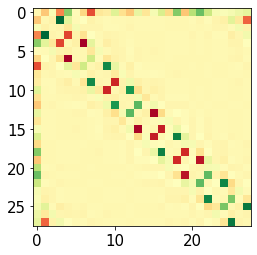

In [24]:
temp = hamils[3]

np.fill_diagonal(temp, 0)

plt.imshow(temp, cmap='RdYlGn')

In [26]:
mg_xyz = load_mg_xyz()

Finished 'load_dcd_file' in 9.575493 secs


[ 1  4  7 10 13 16 19 22 25]
[16 10 13 19  1 22 25  7  4 15 14 17 12 26 11 20 21 18  9 23  0  6 24  5
  2  8  3]


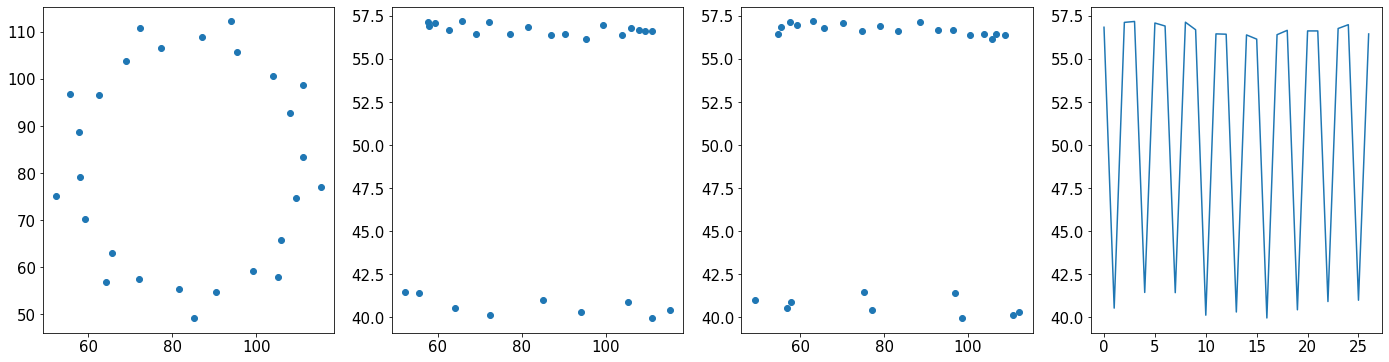

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6))

ax[0].scatter(mg_xyz[0][:,0], mg_xyz[0][:,1])
ax[1].scatter(mg_xyz[0][:,0], mg_xyz[0][:,2])
ax[2].scatter(mg_xyz[0][:,1], mg_xyz[0][:,2])

print(np.where(mg_xyz[0][:,2] < 47.5)[0])

print(np.argsort(mg_xyz[0][:,2]))

ax[3].plot(mg_xyz[0][:,2])

In [28]:
b800 = list(range(2, 28, 3))
b850a = list(range(1, 28, 3))
b850b = list(range(3, 28, 3))
rings = [0] + b800 + b850a + b850b

print(b800)

[2, 5, 8, 11, 14, 17, 20, 23, 26]


. . . . . . . . . . . . . . . . . . . . . done!


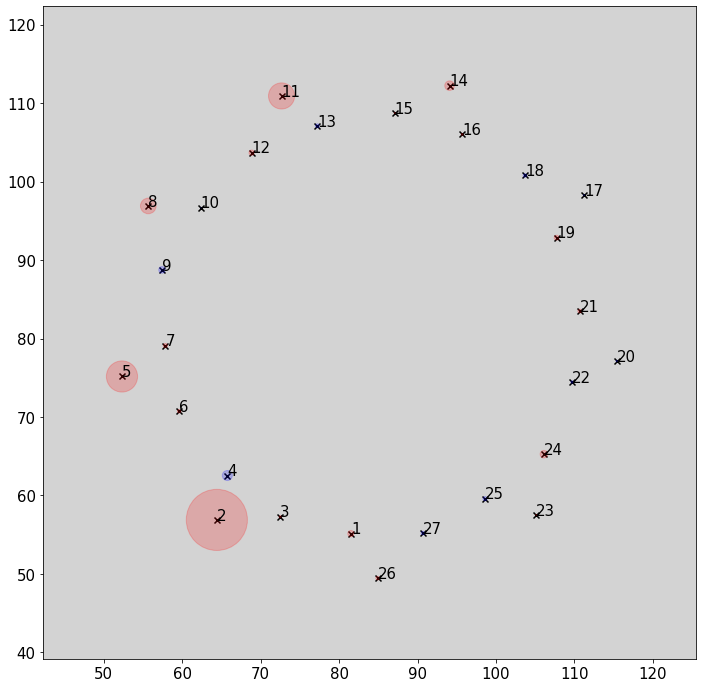

In [174]:
fig, ax = plt.subplots(figsize=(12,12))

frames = 200
fps=10
nSeconds = int(frames / fps)

max_x = np.max(mg_xyz[:, :, 0]) + 10
min_x = np.min(mg_xyz[:, :, 0]) - 10

max_y = np.max(mg_xyz[:, :, 1]) + 10
min_y = np.min(mg_xyz[:, :, 1]) - 10

def plot_coeff(i):
    ax.clear()
    
    ax.set_aspect('equal')
    ax.set_facecolor('lightgrey')
    ax.set_xlim((min_x, max_x))
    ax.set_ylim((min_y, max_y))
    
    if i % fps == 0 :
        print(".", end=" ")
    
    column = np.argmax(np.square(eigvec[i][2]))

    #column = int(args[i])
    
    #for column in range(28): 
    coeff = eigvec[i][:,column]    
    
    for e, c in enumerate(coeff[1:]):
        radius = 5 * abs(c)
        circle = matplotlib.patches.Circle((mg_xyz[i][e][0], mg_xyz[i][e][1]), radius=radius, alpha=0.2)

        ax.annotate(e+1, (mg_xyz[i][e][0], mg_xyz[i][e][1]))

        if c > 0:
            circle.set(color='red')
        if c < 0:
            circle.set(color='blue')

        ax.add_patch(circle)

    scat = ax.scatter(mg_xyz[i][:,0], mg_xyz[i][:,1], marker='x', color='black')
    
    return [scat]

anim = animation.FuncAnimation(
                               fig,
                               plot_coeff, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('../movies/site_2.mp4', fps=fps, extra_args=['-vcodec', 'libx264'],dpi=170)

print("done!")

In [169]:
density = np.square(eigvec)
diff = np.zeros(density.shape)

for f in range(density.shape[0]):
    for i,j in itertools.product(range(28), range(28)):
        diff[f][i][j] = np.linalg.norm(density[f][:,i] - density[max(f-1, 0)][:,j])

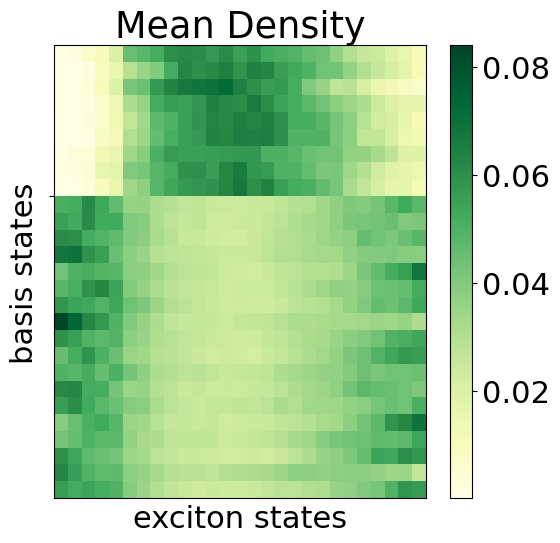

In [161]:
fig = plt.figure(figsize=(6,6), dpi=100)

plt.title("Mean Density")
plt.yticks([8.5], [""])
plt.xticks([])

plt.ylabel("basis states")
plt.xlabel("exciton states")

mean = np.mean(density, axis=0)
im = plt.imshow(mean[rings][1:, 1:], aspect='auto', cmap='YlGn')

#fig.colorbar(im, ticks=np.linspace(0, 1, 11));
fig.colorbar(im);

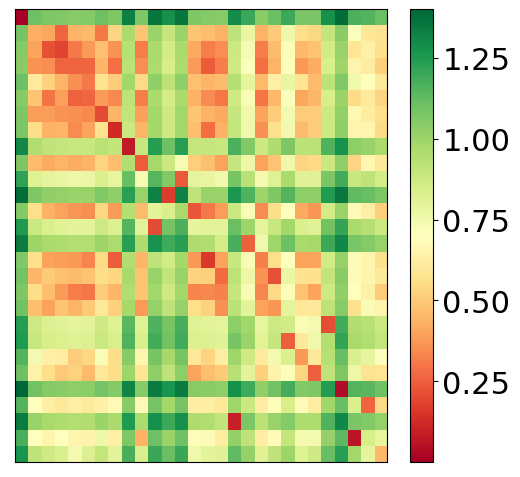

In [170]:
fig = plt.figure(figsize=(6,6), dpi=100)

plt.xticks([])
plt.yticks([])

im = plt.imshow(diff[3], aspect='auto', cmap='RdYlGn')

#fig.colorbar(im, ticks=np.linspace(0, 1, 11));
fig.colorbar(im);

.........................................................................................................................................................................................................Done!


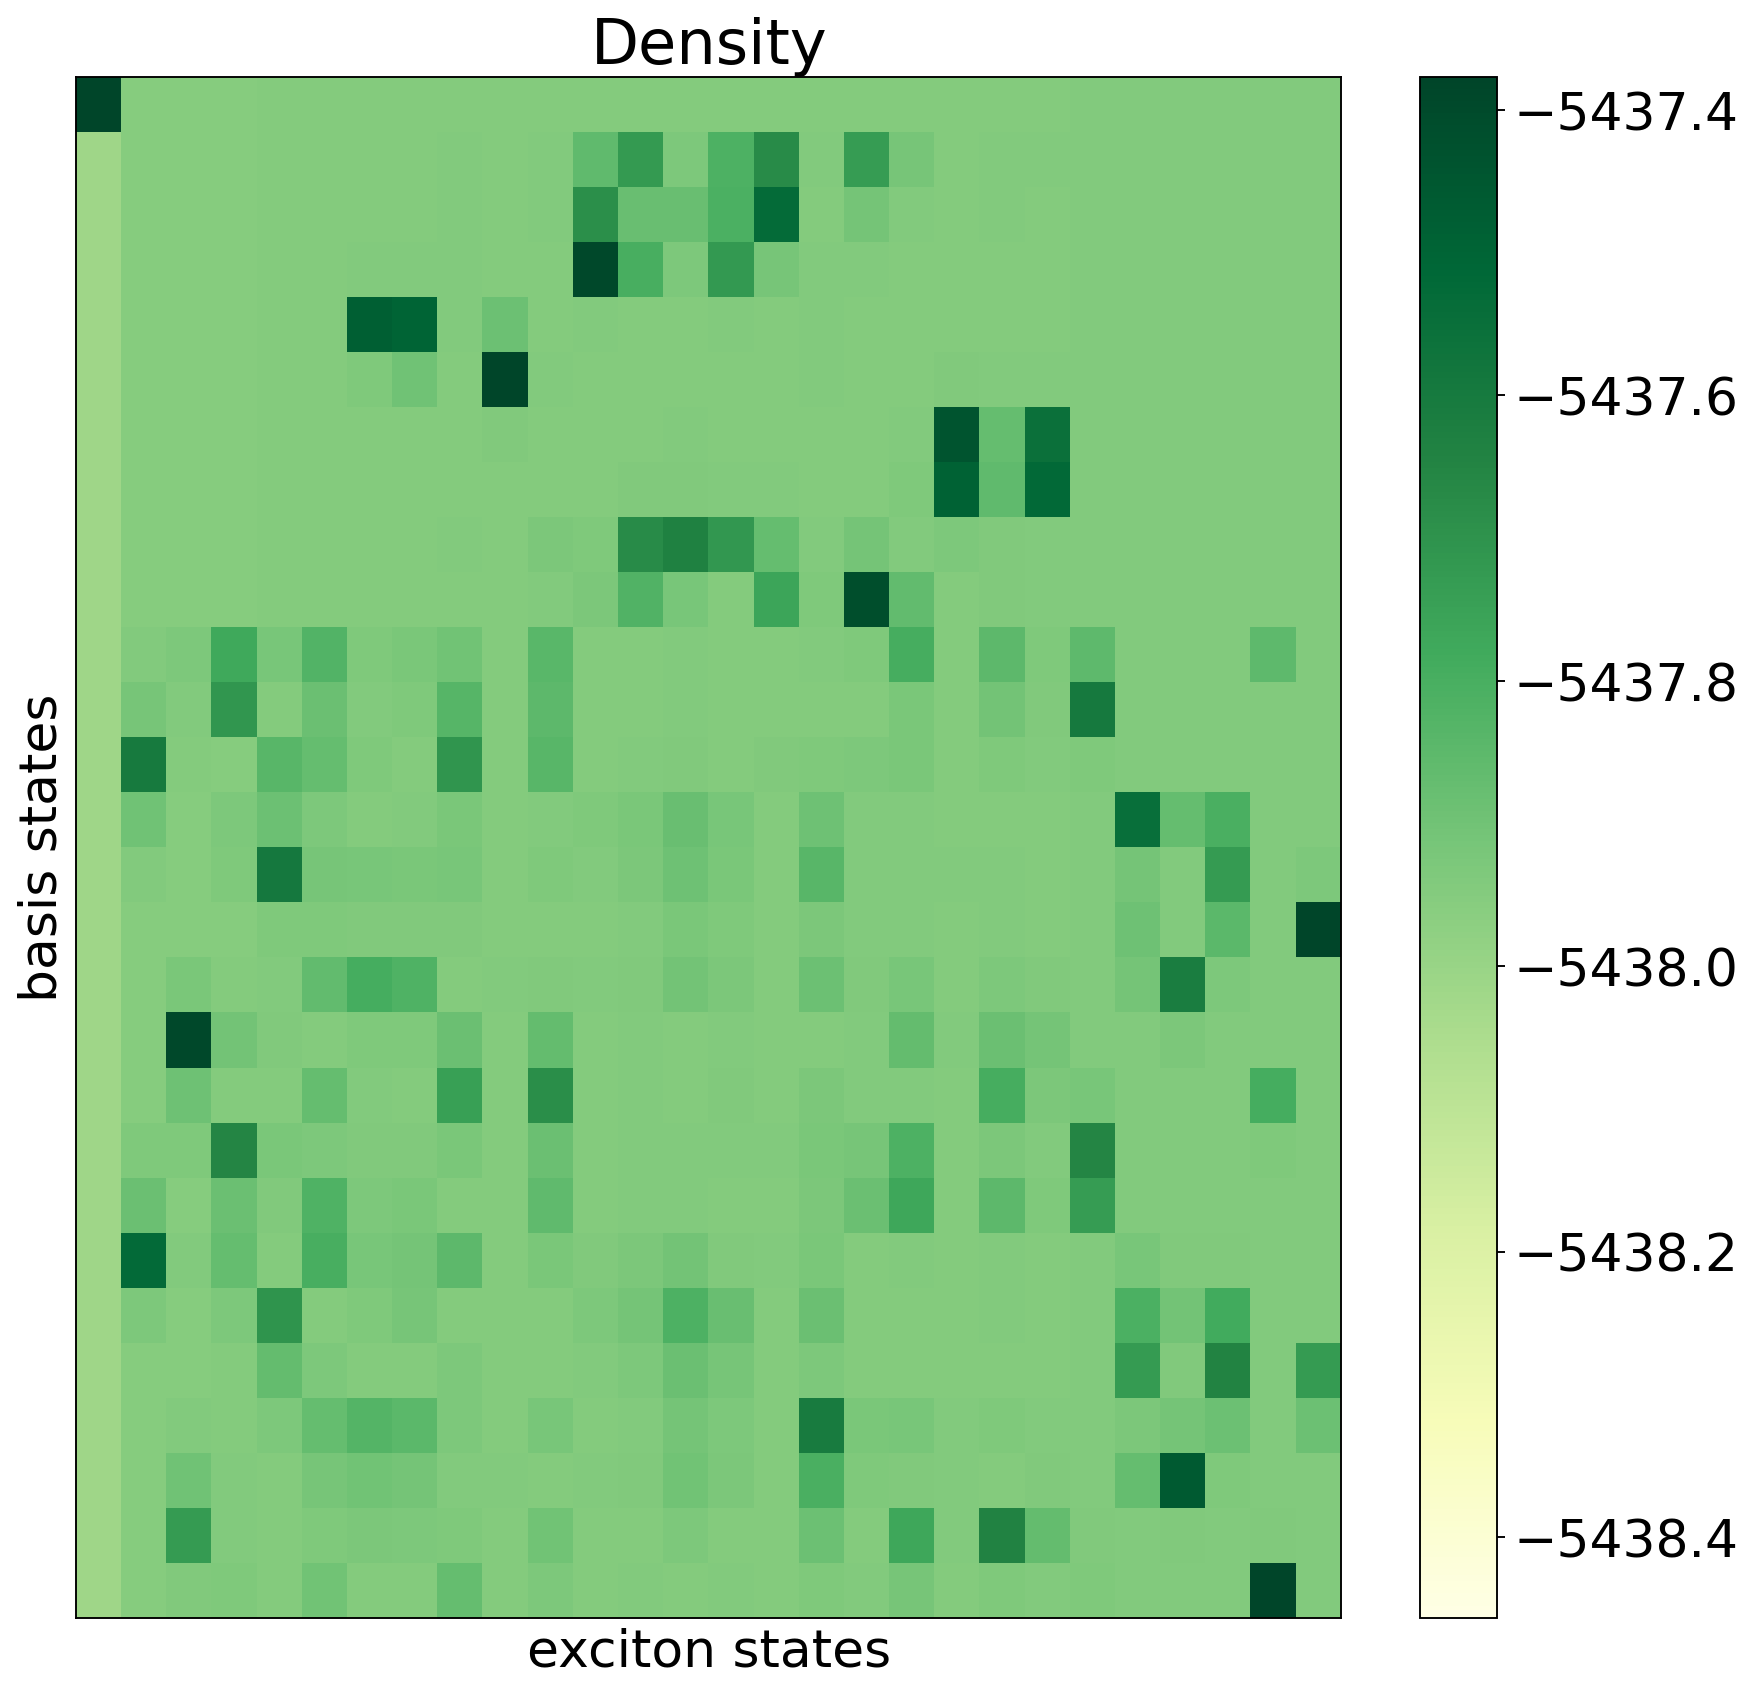

In [224]:
frames = 2000
fps = 10
nSeconds = int(frames / fps)

fig = plt.figure(figsize=(12,12), dpi=170)

plt.title("Density")
plt.xticks([])
plt.yticks([])

plt.ylabel("basis states")
plt.xlabel("exciton states")

vmax = np.max(eigval)
vmin = np.min(eigval)

energy_mat = np.tile(eigval[0].T, (28, 1))
a = density[0] + energy_mat
im = plt.imshow(a[rings], aspect='auto', cmap='YlGn', vmin=vmin, vmax=vmax)

fig.colorbar(im)

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )
        
    energy_mat = np.tile(eigval[i].T, (28, 1))
    
    plot_mat = density[i] + energy_mat
    
    im.set_array(plot_mat[rings])
    return [im]

anim = animation.FuncAnimation(
                               fig,
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('energy_breathing.mp4', fps=fps, extra_args=['-vcodec', 'libx264'],dpi=170)

print('Done!')

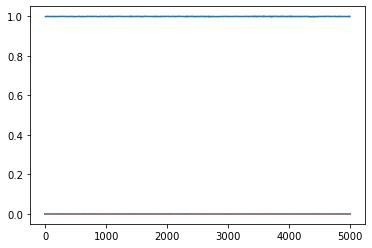

In [119]:
plt.plot(np.square(eigvec[:,:,0]));